# Identifying demand in New York to start Gym and Fitness centers

### Importing all necessary libraries

In [139]:
import numpy as np                                     # library to handle data in a vectorized manner

import pandas as pd                                    # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json                                            # library to handle JSON files

import requests                                        # library to handle requests
from pandas.io.json import json_normalize              # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans


### Downloading and Loading New York Neighborhood Data

In [140]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [141]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [142]:
neighborhoods_data = newyork_data['features']

In [143]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [144]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [145]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [146]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [147]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [148]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Getting Foursquare Credentials

In [153]:
CLIENT_ID = 'DTPZAXQFB3HR2XSXHNHCPDMBA5YYDR1CHX2QNHMG4BTV4JHX' # your Foursquare ID
CLIENT_SECRET = 'NOPCZF4ORMPQT0REK13LL40YAVIUD2HXNK1VRE03ATKDC3FI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DTPZAXQFB3HR2XSXHNHCPDMBA5YYDR1CHX2QNHMG4BTV4JHX
CLIENT_SECRET:NOPCZF4ORMPQT0REK13LL40YAVIUD2HXNK1VRE03ATKDC3FI


### Getting venue data from Foursquare API 

In [156]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [157]:
neighborhoods_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )


Wakefield


KeyError: 'groups'

In [99]:
print(neighborhoods_venues.shape)
neighborhoods_venues.head()

(10381, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant


In [100]:
print('There are {} uniques categories.'.format(len(neighborhoods_venues['Venue Category'].unique())))

There are 428 uniques categories.


### Creating features - Regrouping venue categories to form specific genres 

In [101]:
def test(row):
    if row['Venue Category'] in ['Adult Boutique','Boutique','Bridal Shop','Clothing Store']:
        val = 'Boutique'
    elif row['Venue Category'] in ['Arcade','Building','Campground','Community Center','Construction & Landscaping','Coworking Space','Event Space','Exhibit','Farmers Market','Field','Fish Market','Flea Market','Heliport','Hostel','Market','Memorial Site','Monument / Landmark','Motel','Newsstand','Office','Other Great Outdoors','Outdoor Sculpture','Pier','Platform','Post Office','Social Club']:
        val = 'Arcade'
    elif row['Venue Category'] in ['Bubble Tea Shop','Cafeteria','Café','Coffee Shop','College Cafeteria','Gaming Cafe','Tea Room']:
        val = 'Cafeteria'
    elif row['Venue Category'] in ['Afghan Restaurant','African Restaurant','American Restaurant','Arepa Restaurant','Argentinian Restaurant','Asian Restaurant','Australian Restaurant','Austrian Restaurant','BBQ Joint','Bagel Shop','Bakery','Bed & Breakfast','Bistro','Brazilian Restaurant','Breakfast Spot','Buffet','Burger Joint','Burrito Place','Cajun / Creole Restaurant','Cambodian Restaurant','Cantonese Restaurant','Caribbean Restaurant','Caucasian Restaurant','Cha Chaan Teng','Chinese Restaurant','Chocolate Shop','Colombian Restaurant','Comfort Food Restaurant','Creperie','Cuban Restaurant','Cupcake Shop','Czech Restaurant','Dessert Shop','Dim Sum Restaurant','Diner','Donut Shop','Dosa Place','Dumpling Restaurant','Eastern European Restaurant','Egyptian Restaurant','Empanada Restaurant','English Restaurant','Ethiopian Restaurant','Falafel Restaurant','Fast Food Restaurant','Filipino Restaurant','Food','Food & Drink Shop','Food Court','Food Stand','Food Truck','French Restaurant','Fried Chicken Joint','Frozen Yogurt Shop','German Restaurant','Gourmet Shop','Greek Restaurant','Halal Restaurant','Hawaiian Restaurant','Himalayan Restaurant','Hot Dog Joint','Hotel','Hotel Bar','Hotel Pool','Hotpot Restaurant','Ice Cream Shop','Indian Chinese Restaurant','Indian Restaurant','Indonesian Restaurant','Israeli Restaurant','Italian Restaurant','Japanese Curry Restaurant','Japanese Restaurant','Jewish Restaurant','Kebab Restaurant','Korean Restaurant','Kosher Restaurant','Latin American Restaurant','Lebanese Restaurant','Malay Restaurant','Mediterranean Restaurant','Mexican Restaurant','Middle Eastern Restaurant','Modern European Restaurant','Molecular Gastronomy Restaurant','Moroccan Restaurant','New American Restaurant','Noodle House','Paella Restaurant','Pakistani Restaurant','Pastry Shop','Persian Restaurant','Peruvian Restaurant','Pie Shop','Pizza Place','Poke Place','Polish Restaurant','Ramen Restaurant','Restaurant','Romanian Restaurant','Russian Restaurant','Sake Bar','Sandwich Place','Scandinavian Restaurant','Seafood Restaurant','Shabu-Shabu Restaurant','Shanghai Restaurant','Snack Place','Soba Restaurant','Soup Place','South American Restaurant','South Indian Restaurant','Southern / Soul Food Restaurant','Spanish Restaurant','Sri Lankan Restaurant','Steakhouse','Street Food Gathering','Sushi Restaurant','Swiss Restaurant','Szechuan Restaurant','Taco Place','Taiwanese Restaurant','Tapas Restaurant','Tex-Mex Restaurant','Thai Restaurant','Tibetan Restaurant','Turkish Restaurant','Udon Restaurant','Varenyky restaurant','Vegetarian / Vegan Restaurant','Venezuelan Restaurant','Veterinarian','Vietnamese Restaurant','Wings Joint','Bar','Beer Bar','Beer Garden','Beer Store','Brewery','Cocktail Bar','Dive Bar','Irish Pub','Liquor Store','Lounge','Nightclub','Nightlife Spot','Other Nightlife','Pub','Tiki Bar','Whisky Bar','Wine Bar','Wine Shop']:
        val = 'Food & Wine'
    elif row['Venue Category'] in ['Convenience Store','Deli / Bodega','Grocery Store']:
        val = 'Grocery'
    elif row['Venue Category'] in ['Boxing Gym','Climbing Gym','Gym','Gym / Fitness Center','Gym Pool','Gymnastics Gym']:
        val = 'Gym'
    elif row['Venue Category'] in ['Gluten-free Restaurant','Health & Beauty Service','Health Food Store','Massage Studio','Organic Grocery','Physical Therapist','Salad Place','Spa','Spiritual Center','Weight Loss Center','Yoga Studio']:
        val = 'Health'
    elif row['Venue Category'] in ['Art Gallery','Art Museum','Arts & Crafts Store','Arts & Entertainment','Auditorium','Bath House','Beach','Beach Bar','Boat or Ferry','Club House','Comedy Club','Concert Hall','Dog Run','Fountain','Garden','Garden Center','General Entertainment','Harbor / Marina','Historic Site','History Museum','Indie Movie Theater','Indie Theater','Jazz Club','Karaoke Bar','Lake','Library','Movie Theater','Multiplex','Museum','Opera House','Outdoors & Recreation','Park','Pedestrian Plaza','Performing Arts Venue','Piano Bar','Playground','Plaza','Pool','Pool Hall','Public Art','Recreation Center','Rest Area','Rock Club','Scenic Lookout','Sculpture Garden','Theater','Theme Park','Theme Park Ride / Attraction','Toy / Game Store']:
        val = 'Recreation'
    elif row['Venue Category'] in ['Athletics & Sports','Baseball Field','Baseball Stadium','Basketball Court','Board Shop','Bowling Alley','College Basketball Court','Golf Course','Mini Golf','Rock Climbing Spot','Skate Park','Skating Rink','Ski Area','Ski Shop','Soccer Field','Sporting Goods Shop','Sports Bar','Sports Club','Surf Spot','Tennis Court','Tennis Stadium','Volleyball Court']:
        val = 'Sports'
    elif row['Venue Category'] in ['Big Box Store','Department Store','Discount Store','Shopping Mall','Supermarket']:
        val = 'Supermarket'
    elif row['Venue Category'] in ['Bus Line','Bus Station','Bus Stop','Metro Station','Train','Train Station']:
        val = 'Public Transport'
    elif row['Venue Category'] in ["Baby Store","Cooking School","Cosmetics Shop","Lingerie Store","Nail Salon","Women's Store"]:
        val = 'Faminine'
        
    else:
        val = row['Venue Category']
    return val

neighborhoods_venues['New Venue Category'] = neighborhoods_venues.apply(test, axis=1)


In [102]:
neighborhoods_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,New Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Food & Wine
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Food & Wine
3,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station,Gas Station
4,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant,Food & Wine


In [103]:
print('There are {} uniques categories.'.format(len(neighborhoods_venues['New Venue Category'].unique())))

There are 143 uniques categories.


### Creating features - Creating dummy features for each venue category

In [104]:
neighborhoods_onehot = pd.get_dummies(neighborhoods_venues[['New Venue Category']], prefix="", prefix_sep="")
neighborhoods_onehot['Neighborhood'] = neighborhoods_venues['Neighborhood'] 
neighborhood = neighborhoods_onehot['Neighborhood']
neighborhoods_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
neighborhoods_onehot.insert(0, 'Neighborhood', neighborhood)

neighborhoods_onehot.head()

,Neighborhood,Accessories Store,Airport Terminal,Antique Shop,Arcade,Astrologer,Auto Garage,Auto Workshop,Automotive Shop,Bank,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bookstore,Boutique,Bridge,Business Service,Butcher,Cafeteria,Camera Store,Candy Store,Check Cashing Service,Cheese Shop,Church,College Academic Building,College Arts Building,College Bookstore,College Stadium,College Theater,Cycle Studio,Dance Studio,Daycare,Design Studio,Distillery,Doctor's Office,Drugstore,Dry Cleaner,Duty-free Shop,Electronics Store,Event Service,Eye Doctor,Factory,Faminine,Farm,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food & Wine,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Grocery,Gym,Hardware Store,Health,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,IT Services,Insurance Office,Intersection,Jewelry Store,Juice Bar,Kids Store,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Martial Arts Dojo,Mattress Store,Medical Center,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Moving Target,Music School,Music Store,Music Venue,Non-Profit,North Indian Restaurant,Optical Shop,Other Repair Shop,Outlet Store,Paper / Office Supplies Store,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pilates Studio,Print Shop,Public Transport,Racetrack,Record Shop,Recording Studio,Recreation,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,River,Roller Rink,Roof Deck,Salon / Barbershop,School,Shipping Store,Shoe Store,Shop & Service,Smoke Shop,Smoothie Shop,Souvlaki Shop,Speakeasy,Sports,Stables,State / Provincial Park,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Tailor Shop,Tanning Salon,Tattoo Parlor,Thrift / Vintage Store,Toll Plaza,Tourist Information Center,Track,Trail,Tree,Used Bookstore,Vape Store,Video Game Store,Video Store,Warehouse Store,Waste Facility,Waterfront
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
neighborhoods_onehot.shape

(10381, 143)

### Creating features - Calculating % penatration of each venue category in neighborhood

In [106]:
neighborhoods_grouped = neighborhoods_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_grouped.head()

,Neighborhood,Accessories Store,Airport Terminal,Antique Shop,Arcade,Astrologer,Auto Garage,Auto Workshop,Automotive Shop,Bank,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bookstore,Boutique,Bridge,Business Service,Butcher,Cafeteria,Camera Store,Candy Store,Check Cashing Service,Cheese Shop,Church,College Academic Building,College Arts Building,College Bookstore,College Stadium,College Theater,Cycle Studio,Dance Studio,Daycare,Design Studio,Distillery,Doctor's Office,Drugstore,Dry Cleaner,Duty-free Shop,Electronics Store,Event Service,Eye Doctor,Factory,Faminine,Farm,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food & Wine,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Grocery,Gym,Hardware Store,Health,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,IT Services,Insurance Office,Intersection,Jewelry Store,Juice Bar,Kids Store,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Martial Arts Dojo,Mattress Store,Medical Center,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Moving Target,Music School,Music Store,Music Venue,Non-Profit,North Indian Restaurant,Optical Shop,Other Repair Shop,Outlet Store,Paper / Office Supplies Store,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pilates Studio,Print Shop,Public Transport,Racetrack,Record Shop,Recording Studio,Recreation,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,River,Roller Rink,Roof Deck,Salon / Barbershop,School,Shipping Store,Shoe Store,Shop & Service,Smoke Shop,Smoothie Shop,Souvlaki Shop,Speakeasy,Sports,Stables,State / Provincial Park,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Tailor Shop,Tanning Salon,Tattoo Parlor,Thrift / Vintage Store,Toll Plaza,Tourist Information Center,Track,Trail,Tree,Used Bookstore,Vape Store,Video Game Store,Video Store,Warehouse Store,Waste Facility,Waterfront
0,Allerton,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.531250,0.0,0.0,0.03125,0.0,0.0,0.0,0.093750,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.454545,0.0,0.0,0.00000,0.0,0.0,0.0,0.090909,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.00000,0.0,0.0,0.0,0.200000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Clusture Modeling - Creating database

In [107]:
neighborhoods_grouped_clustering = neighborhoods_grouped.drop('Neighborhood', 1)

### Find the appropriate cluster number

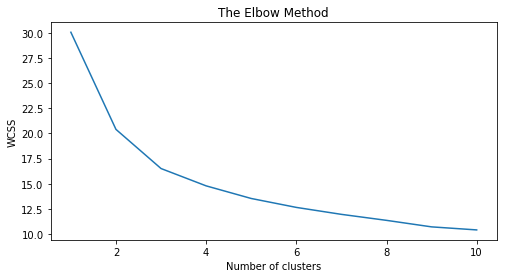

In [108]:
plt.figure(figsize=(8, 4))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(neighborhoods_grouped_clustering)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Cluster Modeling - Running algorithm with 3 cluster number

In [109]:
num_clusters = 3

k_means = KMeans(init="k-means++", random_state=42, n_clusters=num_clusters, n_init=12)
k_means.fit(neighborhoods_grouped_clustering)
labels = k_means.labels_

print(labels)

[0 2 2 2 0 2 0 2 2 0 2 0 2 2 0 1 0 0 2 2 2 0 0 0 1 2 1 2 2 1 2 0 0 0 0 2 2
 0 0 0 1 0 2 0 0 0 0 0 2 0 0 0 0 0 2 1 2 0 0 2 0 0 2 0 0 0 0 0 2 0 0 0 0 0
 2 0 2 2 0 2 0 0 0 2 2 2 0 2 0 0 0 1 2 0 1 0 0 0 0 0 0 2 2 0 0 0 2 2 2 0 0
 0 0 0 0 2 0 2 0 0 0 0 0 1 0 2 2 0 2 2 0 2 0 0 0 0 0 0 0 0 2 1 0 0 0 2 0 0
 2 2 0 2 2 0 0 0 0 0 0 2 1 2 0 0 0 0 2 2 0 0 2 0 2 0 0 0 0 1 0 2 0 0 0 2 0
 0 1 2 0 0 2 0 0 0 0 0 0 0 2 2 2 0 0 0 0 2 0 2 0 2 0 0 2 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 2 2 0 1 0 0 0 2 0 2 0 2 0 2 0 2 0 2 0 2 1 2 1 2 0 0 2 2 0 2
 0 2 0 2 0 0 0 0 0 1 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 2 2 0 0 2 2 2
 2 0 0 0 0]


### Cluster level data aggregation to find distinct category penatration patterns

In [111]:
neighborhoods_grouped_clustering['Labels'] = labels

In [112]:
neighborhoods_grouped_clustering.groupby('Labels').count()

,Accessories Store,Airport Terminal,Antique Shop,Arcade,Astrologer,Auto Garage,Auto Workshop,Automotive Shop,Bank,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bookstore,Boutique,Bridge,Business Service,Butcher,Cafeteria,Camera Store,Candy Store,Check Cashing Service,Cheese Shop,Church,College Academic Building,College Arts Building,College Bookstore,College Stadium,College Theater,Cycle Studio,Dance Studio,Daycare,Design Studio,Distillery,Doctor's Office,Drugstore,Dry Cleaner,Duty-free Shop,Electronics Store,Event Service,Eye Doctor,Factory,Faminine,Farm,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Food & Wine,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gift Shop,Grocery,Gym,Hardware Store,Health,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,IT Services,Insurance Office,Intersection,Jewelry Store,Juice Bar,Kids Store,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Martial Arts Dojo,Mattress Store,Medical Center,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Moving Target,Music School,Music Store,Music Venue,Non-Profit,North Indian Restaurant,Optical Shop,Other Repair Shop,Outlet Store,Paper / Office Supplies Store,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piercing Parlor,Pilates Studio,Print Shop,Public Transport,Racetrack,Record Shop,Recording Studio,Recreation,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,River,Roller Rink,Roof Deck,Salon / Barbershop,School,Shipping Store,Shoe Store,Shop & Service,Smoke Shop,Smoothie Shop,Souvlaki Shop,Speakeasy,Sports,Stables,State / Provincial Park,Storage Facility,Street Art,Strip Club,Supermarket,Supplement Shop,Tailor Shop,Tanning Salon,Tattoo Parlor,Thrift / Vintage Store,Toll Plaza,Tourist Information Center,Track,Trail,Tree,Used Bookstore,Vape Store,Video Game Store,Video Store,Warehouse Store,Waste Facility,Waterfront
Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187
1,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
2,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96,96


In [113]:
segment_data = neighborhoods_grouped_clustering.groupby('Labels').mean()
segment_data = segment_data.T
segment_data = segment_data[(segment_data[0]>0.010101) | (segment_data[1]>0.010101) | (segment_data[2]>0.010101)].T


In [114]:
segment_data

,Arcade,Bank,Boutique,Cafeteria,Eye Doctor,Faminine,Food & Wine,Grocery,Gym,Health,Intersection,Pharmacy,Public Transport,Recreation,River,Sports,Supermarket,Trail
Labels,,,,,,,,,,,,,,,,,,
0,0.013877,0.020693,0.007002,0.035716,0.000000,0.011314,0.582937,0.056876,0.017432,0.018977,0.001613,0.023008,0.017822,0.054306,0.000000,0.016228,0.022010,0.000754
1,0.043519,0.005556,0.000000,0.000000,0.018519,0.011111,0.043519,0.035185,0.005556,0.000000,0.018519,0.000000,0.066667,0.616667,0.011111,0.096296,0.011111,0.011111
2,0.023348,0.014404,0.011400,0.037816,0.000000,0.016193,0.330180,0.100891,0.024771,0.021557,0.009388,0.024284,0.097512,0.097758,0.000000,0.030878,0.044409,0.001207


### Finding correlation of 'Gym' penatration with other venue categories

In [115]:
corr_data = segment_data.corr(method='pearson')

In [116]:
corr_data = corr_data.reset_index()

In [117]:
corr_data = corr_data[['index', 'Gym']]
corr_data = corr_data[corr_data['index'] != 'Gym']
corr_data = corr_data.rename(columns={'index': 'Venue Category','Gym':'Correlation'})
corr_data = corr_data.sort_values('Correlation', ascending=False).reset_index(drop=True)

Text(0, 0.5, 'Correlation')

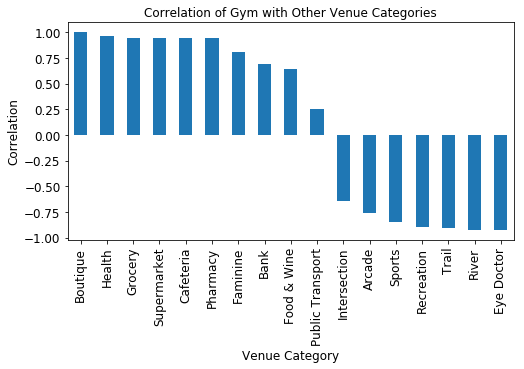

In [118]:
ax = corr_data.plot(kind='bar', x='Venue Category', y='Correlation', title ="Correlation of Gym with Other Venue Categories", figsize=(8, 4), legend=False, fontsize=12)
ax.set_xlabel("Venue Category", fontsize=12)
ax.set_ylabel("Correlation", fontsize=12)

### Understanding Segments (Clusters) profiles

In [119]:
segment_column_list = segment_data.columns

from sklearn import preprocessing
normalized_segment_data = preprocessing.normalize(segment_data)
normalized_segment_data = pd.DataFrame(normalized_segment_data)
normalized_segment_data.columns = segment_column_list

In [120]:
normalized_segment_data = normalized_segment_data.T

In [121]:
normalized_segment_data

,0,1,2
Arcade,0.023445,0.068786,0.061206
Bank,0.034961,0.008781,0.037758
Boutique,0.011830,0.000000,0.029884
Cafeteria,0.060342,0.000000,0.099133
Eye Doctor,0.000000,0.029271,0.000000
Faminine,0.019115,0.017562,0.042447
Food & Wine,0.984872,0.068786,0.865541
Grocery,0.096092,0.055614,0.264479
Gym,0.029451,0.008781,0.064936
Health,0.032062,0.000000,0.056509


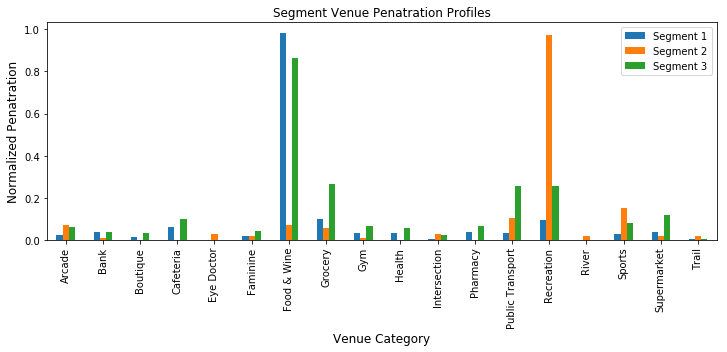

In [122]:
ax = normalized_segment_data.plot(kind='bar', title="Segment Venue Penatration Profiles", figsize=(12, 4))
ax.set_xlabel("Venue Category", fontsize=12)
ax.set_ylabel("Normalized Penatration", fontsize=12)
ax.legend(["Segment 1", "Segment 2", "Segment 3"])